In [1]:
import numpy as np
import pandas as pd 
import datetime
import matplotlib.pyplot as plt 
from statsmodels.regression import linear_model
from statsmodels.api import add_constant
plt.ioff()

## Reading our dataset into a pandas dataframe

In [2]:
data = pd.read_csv('data.csv', sep=',', encoding=None, header=0)
data.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2020,continentExp
0,23/10/2022,23,10,2022,3557.0,0.0,Austria,AT,AUT,8901064,Europe
1,22/10/2022,22,10,2022,5494.0,4.0,Austria,AT,AUT,8901064,Europe
2,21/10/2022,21,10,2022,7776.0,4.0,Austria,AT,AUT,8901064,Europe
3,20/10/2022,20,10,2022,8221.0,6.0,Austria,AT,AUT,8901064,Europe
4,19/10/2022,19,10,2022,10007.0,8.0,Austria,AT,AUT,8901064,Europe


In [3]:
# ### Basic description of our dataset 

# Making sure that our 'date' key is actually of a date-related dtype so we can sort correctly. We choose to work with 
# the 'datetime' dtype because it is more convenient for visually inspecting and showcasing the progress of our analysis 
data['dateRep'] = pd.to_datetime(data['dateRep'], format='%d/%m/%Y')
print(f"Date of First Observation: {data['dateRep'].min()}\nDate of Last Observation: {data['dateRep'].max()}")
print(f"The total number of observations is: {data.shape[0]}")
print(f"The dataset contains data for {len(data['countriesAndTerritories'].unique())} countries.")

Date of First Observation: 2020-01-01 00:00:00
Date of Last Observation: 2022-10-26 00:00:00
The total number of observations is: 28729
The dataset contains data for 30 countries.


### Basic description of our dataset 

The dataset contains daily observations for the number of positive COVID-19 cases and COVID-related deaths from 30 countries in the EU/EEA region. The data have a daily frequency and the time interval the span lies 
from Jan 1, 2020 to Oct 26, 2022.

The total number of observations is 28715. 

**We have selected the number of positive covid-19 cases to be our forecast variable, and we will concentrate in data referring 
to Greece for that.**

We begin our analysis by addressing a very significant sign of measurement error, which is negative observations of cases. 
Cases can never be negative, so we will drop those records (NaN values will appear in their position later in our analysis, 
and we will treat them properly). That is because they will otherwise create significant problems in our forecasts.
There are 14 negative values in our dataset.

In [4]:
print(f"There are {data[data['cases'] < 0].shape[0]} negative values in our dataset.")  # show the first 5 lines of this as an example of this problem of our data (report)

There are 14 negative values in our dataset.


In [5]:
data.drop(data[data['cases'] < 0].index, axis=0, inplace=True)

An important inconsistency that we discovered in our data has to do with the fact that, even though the available data for each
country are of a daily frequency (with the exception of some missing values), the observations for each do not begin and end in 
the same span. That creates imbalances in the number of missing or NaN values between the various countries, something that needs 
to be addressed in the comparative analysis performed in question E. 

To account for the previous, as well as for NaN and missing values in each country, we started by building a dataframe that
contains daily records for each of the country, and assigns a NaN value if there is no observation for a specific (date, country)
pair. Thus, our dataframe will culminate in containing one row for each possible (date, country) pair. The resulting dataframe 
(called 'res') will be used to extract the data we'll use for our analysis.

In [6]:
# We begin by building a dataframe with just one column, the 'date' column which spans the whole time interval we have data on, 
# breaking down in daily observations. 
date_col = [] 
first_date = datetime.datetime(2020,1,1)
last_date = datetime.datetime(2022,10,26)
no_days = (last_date - first_date).days
for i in range(no_days+1): 
    date_col.append((last_date-datetime.timedelta(days=i)).strftime(format='%d/%m/%Y'))
date_col.sort(reverse=False) 

temp = pd.DataFrame(data=[date_col]).T
temp.columns=['date']
temp['date'] = pd.to_datetime(temp['date'], format='%d/%m/%Y')
temp.sort_values(by='date', ascending=True, inplace=True)  # we want the 'date' column to be in sorted in ascending odde
print(list(temp['date'])[0], list(temp['date'])[-1])
temp.reset_index(inplace=True)
temp.drop('index',axis=1,inplace=True)

2020-01-01 00:00:00 2022-10-26 00:00:00


In [7]:
# Now we cross join this with the 'countriesAndTerritories' column of our initial dataframe, so as to get each possible combo
# of 'date' and country values.
temp = pd.merge(temp, data[['countriesAndTerritories']], how='cross')
# In its initial form, and for a given country, this will contain as many rows for each specific day as the number of observations
# there exist in total for that country. Thus, we drop duplicates
temp.drop_duplicates(inplace=True)
temp.reset_index(inplace=True)
temp.drop(['index'], axis=1, inplace=True)
temp.head()

,date,countriesAndTerritories
0,2020-01-01,Austria
1,2020-01-01,Belgium
2,2020-01-01,Bulgaria
3,2020-01-01,Croatia
4,2020-01-01,Cyprus


We'll now create a custom key that we're going to use in order to merge this df with the 'data' df. We will perform a 
left outer merge, so as to keep all records from 'temp' and only those that actually contain information from the 'data' df, 
assigning nan values to the rest. 

In [8]:
# The key will be of the form DatetimeCountry, which is consisted of information found in both dataframes. 
# First, we construct it in the 'temp' df
temp_key = [] 
for i in range(temp.shape[0]):
    temp_key.append(str(temp['date'][i]) + str(temp['countriesAndTerritories'][i]))

temp['key'] = temp_key

In [9]:
# Now we construct it in the 'data' df
data.reset_index(inplace=True)
data.drop('index', axis=1, inplace=True)
data_key = [] 
for i in range(data.shape[0]):
    data_key.append(str(data['dateRep'][i]) + str(data['countriesAndTerritories'][i]))
data['key'] = data_key

In [10]:
# Performing the final merge 
res = pd.merge(temp, data, on='key', how='outer')
res.drop(['dateRep','month','year','day','countriesAndTerritories_y','geoId','countryterritoryCode','continentExp','key','popData2020'], axis=1, inplace=True)
res['NA'] = np.where(res['cases'].isna(), True, False)
res.head()

,date,countriesAndTerritories_x,cases,deaths,NA
0,2020-01-01,Austria,NaN,NaN,True
1,2020-01-01,Belgium,NaN,NaN,True
2,2020-01-01,Bulgaria,NaN,NaN,True
3,2020-01-01,Croatia,NaN,NaN,True
4,2020-01-01,Cyprus,NaN,NaN,True


In [11]:
# Calculating the number of NaN values per country
non_na_count = pd.pivot_table(res, index='countriesAndTerritories_x', values='NA', aggfunc='sum')['NA']
print(non_na_count.sort_values(ascending=False))

countriesAndTerritories_x
Iceland          250
Cyprus           237
Spain            150
Denmark          118
Romania          106
Portugal          96
Liechtenstein     82
Slovakia          76
Ireland           72
Bulgaria          68
Malta             67
Slovenia          65
Poland            64
Netherlands       63
Hungary           62
Belgium           62
Greece            60
Latvia            60
Austria           59
Estonia           58
Croatia           58
Italy             57
Luxembourg        57
Norway            51
Sweden            48
Germany           38
Lithuania         34
France            27
Czechia           27
Finland            6
Name: NA, dtype: int64


In [12]:
# We will now proceed to find which 10 countries we will take into consideration for our last question, and 
# then we will perform the rest of the cleaning.

# We'll show the min and max population of countries in our dataset. We believe that it is important to study countries whose
# population doesn't differ much, bc the size of a population could affect how the pandemic progresses, so that our A/F ratios in the last question
# couldn't be adequate measures for comparing forecasts bc they reflect different fundamental conditions.
data['popData2020'] = data['popData2020'].astype('int64')
print(f"Minimum population: {data['popData2020'].min()}, Maximum population: {data['popData2020'].max()}")

Minimum population: 38747, Maximum population: 83166711


In [13]:
# Inspecting the population of various countries to think of a country selection strategy: 
data[['countriesAndTerritories','popData2020']].sort_values('popData2020').drop_duplicates()

,countriesAndTerritories,popData2020
17081,Liechtenstein,38747
13054,Iceland,364134
19867,Malta,514564
19059,Luxembourg,626108
4341,Cyprus,888005
6843,Estonia,1328976
15599,Latvia,1907675
26517,Slovenia,2095861
17967,Lithuania,2794090
3472,Croatia,4058165


We see that many countries in our dataframe have similar population sizes, close to the (perceived) median. 
Thus, we'll initially find the countries whose population sizes fall in the middle 50% of the population sizes' distribution:  

In [14]:
# finding the middle 50% of the population sizes in our dataset
q1 = data['popData2020'].quantile(q=0.25)
q3 = data['popData2020'].quantile(q=0.75)
print(f'25th percentile: {int(q1)}, 75th percentile: {int(q3)}')

25th percentile: 2095861, 75th percentile: 11522440


In [15]:
res_countries = data[['countriesAndTerritories','popData2020']][data['popData2020'].between(q1,q3)].drop_duplicates()

In [16]:
print(f"There are {res_countries.shape[0]} countries with population sizes that fall in the middle 50% of the distribution.")

There are 16 countries with population sizes that fall in the middle 50% of the distribution.


In [17]:
# We select the 'middle' 12 (based on their sorted population sizes) of them
res_countries[2:-2].sort_values('popData2020')

,countriesAndTerritories,popData2020
17180,Lithuania,2794090
2901,Croatia,4058165
13331,Ireland,4964440
21079,Norway,5367580
24883,Slovakia,5457873
7572,Finland,5525292
5669,Denmark,5822763
1939,Bulgaria,6951482
11561,Hungary,9769526
23025,Portugal,10295909


In [18]:
# We see that Greece is contained in those, so we just need to drop 1 country to get our 1 (Greece) + 10 countries to analyze.
# That country will be Denmark, as from our previous analysis we saw that it had a much bigger count of NaN values than the rest. 
print(non_na_count.loc[res_countries[2:-2].sort_values('popData2020')['countriesAndTerritories']])

countriesAndTerritories_x
Lithuania     34
Croatia       58
Ireland       72
Norway        51
Slovakia      76
Finland        6
Denmark      118
Bulgaria      68
Hungary       62
Portugal      96
Czechia       27
Greece        60
Name: NA, dtype: int64


As for the time period's data we're going to study, we select a random interval for Greece to be Mar 1, 2020 to Mar 1, 2022. 
We see that it happens so that there is no NaN value for cases in Greece during that period. That
is also going to be the time period under study for the rest of the countries as well

In [19]:
res = res[res['countriesAndTerritories_x'].isin((res_countries[2:-2].sort_values('popData2020')['countriesAndTerritories'])) & (res['countriesAndTerritories_x'] != 'Denmark')]
final = res[(res['date'] >= datetime.datetime(2020,3,1)) & (res['date'] <= datetime.datetime(2022,3,1))]
final.head()

,date,countriesAndTerritories_x,cases,deaths,NA
1802,2020-03-01,Bulgaria,NaN,NaN,True
1803,2020-03-01,Croatia,2.0,0.0,False
1805,2020-03-01,Czechia,3.0,0.0,False
1808,2020-03-01,Finland,1.0,0.0,False
1811,2020-03-01,Greece,2.0,0.0,False


# Data Cleaning
### Missing values detection

In [20]:
# we should perform this on all of the 'final' df's records, so as to also account for the data points we have on the rest 
# of the countries we're going to work with in question E
for country in final['countriesAndTerritories_x'].unique():  # replace NaNs of each country with its next chronologically case count
    all_country = final[final['countriesAndTerritories_x'] == country]  # everything is already sorted in chronological order, 
    # so indexes with higher value will definitely correspond to later observartions
    fix = all_country.fillna(method='bfill')['cases']
    final.loc[:,'cases'][final['countriesAndTerritories_x'] == country]= fix

/var/folders/fp/b19fbw2j41z9_lyxq1cyd88h0000gn/T/ipykernel_10940/768688806.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final.loc[:,'cases'][final['countriesAndTerritories_x'] == country]= fix
/var/folders/fp/b19fbw2j41z9_lyxq1cyd88h0000gn/T/ipykernel_10940/768688806.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final.loc[:,'cases'][final['countriesAndTerritories_x'] == country]= fix
/var/folders/fp/b19fbw2j41z9_lyxq1cyd88h0000gn/T/ipykernel_10940/768688806.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

### Outliers detection

This we will apply on the greek data

In [21]:
gr_data = final[(final['countriesAndTerritories_x'] == 'Greece') & (final['date'] <= datetime.datetime(2022,3,1)) & (final['date'] >= datetime.datetime(2020,3,1))]
gr_data.drop('deaths',axis=1,inplace=True)
gr_data.reset_index(inplace=True)
gr_data.drop('index', axis=1, inplace=True)
print(f"There are {sum(gr_data['cases'].isna())} NaN values for positive cases in Greece in that period.")

There are 0 NaN values for positive cases in Greece in that period.


/var/folders/fp/b19fbw2j41z9_lyxq1cyd88h0000gn/T/ipykernel_10940/3826458100.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gr_data.drop('deaths',axis=1,inplace=True)
/var/folders/fp/b19fbw2j41z9_lyxq1cyd88h0000gn/T/ipykernel_10940/3826458100.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gr_data.drop('index', axis=1, inplace=True)


In [22]:
print(f"There are {gr_data.shape[0]} observations regarding Greece.")

There are 731 observations regarding Greece.


There are 7 outliers, comprising 23.0% of the available data.


/var/folders/fp/b19fbw2j41z9_lyxq1cyd88h0000gn/T/ipykernel_10940/505823557.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gr_march['Z-Score'] = (gr_march['cases'] - gr_march['cases'].mean()) / gr_march['cases']


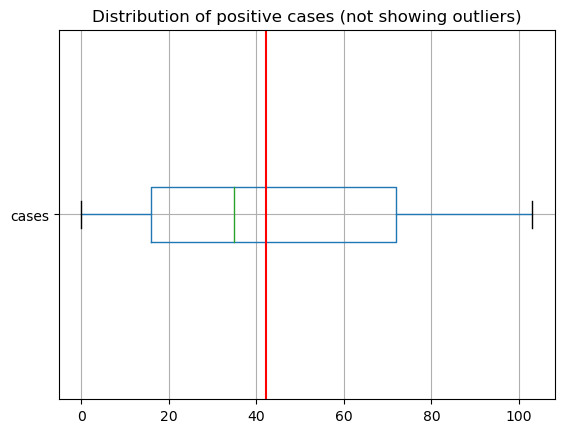

In [23]:
gr_march = gr_data[(gr_data['date'] >= datetime.datetime(2020,3,1)) & (gr_data['date'] <= datetime.datetime(2020,3,31))]
threshold = 3 
gr_march['Z-Score'] = (gr_march['cases'] - gr_march['cases'].mean()) / gr_march['cases']
gr_outliers = gr_march[abs(gr_march['Z-Score']) > threshold]  # epileksame afto to method logw toy oti einai to pio synhthes, bebaia - the transmission of a virus, especially in the setting of the early 
print(f"There are {gr_outliers.shape[0]} outliers, comprising {round(gr_outliers.shape[0]/gr_march.shape[0], 2) * 100}% of the available data.")
gr_march.boxplot('cases', vert=False, showfliers=True)
plt.title('Distribution of positive cases (not showing outliers)')
plt.axvline(gr_march['cases'].mean(), color='red')
plt.show()

### Data inconsistencies

In [24]:
### Data inconsistency: observations are stored in different formats (?)
gr_data['cases'].dtype  # pandas col, den ginetai na mhn einai to idio, tha mporouse na symbei an eixame polla data sources kai 
# kaname kapoio join

dtype('float64')

Another source of data inconsistency would be having data on the same variable(s)/attributes being stored in different formats; 
However, that is not a possibility here, since we're only using a single source of data, so no joining of tables is performed.

# B

In [25]:
gr_data['cases'] = gr_data['cases'].astype('int32')
gr_data.head()

/var/folders/fp/b19fbw2j41z9_lyxq1cyd88h0000gn/T/ipykernel_10940/2197219036.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gr_data['cases'] = gr_data['cases'].astype('int32')


,date,countriesAndTerritories_x,cases,NA
0,2020-03-01,Greece,2,False
1,2020-03-02,Greece,0,False
2,2020-03-03,Greece,1,False
3,2020-03-04,Greece,1,False
4,2020-03-05,Greece,22,False


## B-a

In [26]:
ba_data = gr_data.copy()
ba_data.drop(['NA'], axis=1, inplace=True)  # 
ba_data.head()

,date,countriesAndTerritories_x,cases
0,2020-03-01,Greece,2
1,2020-03-02,Greece,0
2,2020-03-03,Greece,1
3,2020-03-04,Greece,1
4,2020-03-05,Greece,22


In [27]:
### 1st method - the Naive approach
# We first create day, month and year indexes so as to better recognize the part of the year/month an observation falls into
ba_data['day'] = [list(ba_data['date'])[i].day for i in range(ba_data.shape[0])]
ba_data['month'] = [list(ba_data['date'])[i].month for i in range(ba_data.shape[0])]
ba_data['year'] = [list(ba_data['date'])[i].year for i in range(ba_data.shape[0])]
ba_data = ba_data[(ba_data['date'] >= datetime.datetime(2020,3,1)) & (ba_data['date'] <= datetime.datetime(2021,2,28))]
ba_data.head()

,date,countriesAndTerritories_x,cases,day,month,year
0,2020-03-01,Greece,2,1,3,2020
1,2020-03-02,Greece,0,2,3,2020
2,2020-03-03,Greece,1,3,3,2020
3,2020-03-04,Greece,1,4,3,2020
4,2020-03-05,Greece,22,5,3,2020


In [28]:
def naive(df_data, year):  # it accepts a dataframe with columns 'date', 'country', 'cases', 'day', 'month', 'year' structure
    proj = []  # list containing our projections
    for row, val in df_data.iterrows():
        if tuple(val)[4] == 3:
            c = tuple(val)[2]
        else:
            c = df_data[(df_data['day'] == tuple(val)[3]) & (df_data['month'] == 3) & (df_data['year'] == year)]['cases'].values[0]
        proj.append(c)
    
    return proj
ba_data['naive'] = naive(ba_data, 2020)
ba_data.head()

,date,countriesAndTerritories_x,cases,day,month,year,naive
0,2020-03-01,Greece,2,1,3,2020,2
1,2020-03-02,Greece,0,2,3,2020,0
2,2020-03-03,Greece,1,3,3,2020,1
3,2020-03-04,Greece,1,4,3,2020,1
4,2020-03-05,Greece,22,5,3,2020,22


In [29]:
### 2nd method - simple moving average method 
# we select a sliding window of length n=7

In [30]:
def SMA(df_data, year):  #  # it accepts a dataframe with columns 'date', 'country', 'cases', 'day', 'month', 'year' structure
    sma = [np.nan] * 7
    sma += [0]*(df_data.shape[0]-7)
    for i in range(7,df_data.shape[0]):
        # check if in march and calculate it properly 
        if ba_data.iloc[i,4] == 3 and df_data.iloc[i,5] == year:
            sma[i] = df_data['cases'][i-7:i].mean()
        else:
        # check if not in march and calculate iteratively, aka based on previous forecasts
        #test.at[i,'cases'] = test['cases'][i-7:i].mean()
            sma[i] = np.mean(sma[i-7:i])

    return sma 

ba_data['SMA'] = SMA(ba_data, 2020)
ba_data.head(8)       

,date,countriesAndTerritories_x,cases,day,month,year,naive,SMA
0,2020-03-01,Greece,2,1,3,2020,2,NaN
1,2020-03-02,Greece,0,2,3,2020,0,NaN
2,2020-03-03,Greece,1,3,3,2020,1,NaN
3,2020-03-04,Greece,1,4,3,2020,1,NaN
4,2020-03-05,Greece,22,5,3,2020,22,NaN
5,2020-03-06,Greece,14,6,3,2020,14,NaN
6,2020-03-07,Greece,21,7,3,2020,21,NaN
7,2020-03-08,Greece,18,8,3,2020,18,8.714286


In [31]:
### 3. Weighted moving average approach
def WMA(df_data, year): 
    wma = [np.nan] * 7
    wma += [0]*(df_data.shape[0]-7)
    for i in range(7,df_data.shape[0]):
        # check if in march and calculate it properly 
        if df_data.iloc[i,4] == 3 and df_data.iloc[i,5] == year:
            wma[i] = np.average(df_data['cases'][i-7:i], weights=[7,6,5,4,3,2,1])
        else:
        # check if not in march and calculate iteratively, aka based on previous forecasts
        #test.at[i,'cases'] = test['cases'][i-7:i].mean()
            wma[i] = np.average(wma[i-7:i], weights=[7,6,5,4,3,2,1])
    
    return wma 

ba_data['wma'] = WMA(ba_data, 2020)
ba_data.head(8)

,date,countriesAndTerritories_x,cases,day,month,year,naive,SMA,wma
0,2020-03-01,Greece,2,1,3,2020,2,NaN,NaN
1,2020-03-02,Greece,0,2,3,2020,0,NaN,NaN
2,2020-03-03,Greece,1,3,3,2020,1,NaN,NaN
3,2020-03-04,Greece,1,4,3,2020,1,NaN,NaN
4,2020-03-05,Greece,22,5,3,2020,22,NaN,NaN
5,2020-03-06,Greece,14,6,3,2020,14,NaN,NaN
6,2020-03-07,Greece,21,7,3,2020,21,NaN,NaN
7,2020-03-08,Greece,18,8,3,2020,18,8.714286,4.928571


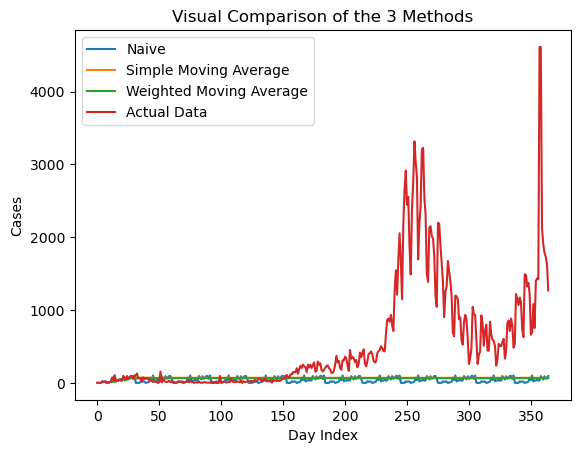

In [32]:
plt.plot(ba_data['naive'], label = 'Naive')
plt.plot(ba_data['SMA'], label = 'Simple Moving Average')
plt.plot(ba_data['wma'], label = 'Weighted Moving Average')
plt.plot(ba_data['cases'], label = 'Actual Data')
plt.xlabel('Day Index')
plt.ylabel('Cases')
plt.title('Visual Comparison of the 3 Methods')
plt.legend()
plt.show()

/Users/chkapsalis/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


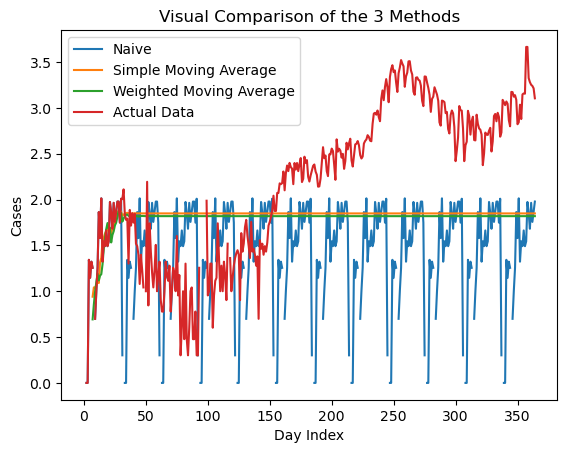

In [33]:
plt.plot(np.log10(ba_data['naive']), label = 'Naive')
plt.plot(np.log10(ba_data['SMA']), label = 'Simple Moving Average')
plt.plot(np.log10(ba_data['wma']), label = 'Weighted Moving Average')
plt.plot(np.log10(ba_data['cases']), label = 'Actual Data')
plt.xlabel('Day Index')
plt.ylabel('Cases')
plt.title('Visual Comparison of the 3 Methods')
plt.legend()
plt.show()

## B-b

In [34]:
# We'll compare the 3 previous methods in 2 ways; one will concern the accuracy of the forecasts they produced, 
# and the other one will consider the bias of them 

# Regarding the first dimension we're going to study -> we'll calculate the MAD (Mean Absolute Deviation), which is a measure
# that uses the same weight for all deviations  

# There are some days on which we had zero cases, which comprise our denominator in the formula, so we find those and exclude 
# them from our calculation
MAD = (((ba_data['cases']-ba_data['naive'])/ba_data['cases']) * 100).round(2)
MAD

0       0.00
1        NaN
2       0.00
3       0.00
4       0.00
       ...  
360    97.48
361    94.84
362    96.71
363    95.46
364    92.51
Length: 365, dtype: float64

In [35]:
print(ba_data['cases'][ba_data['cases'] == 0])  # there indeed exist obs as such, so our concern is valid

1      0
8      0
49     0
94     0
96     0
97     0
98     0
117    0
Name: cases, dtype: int32


In [36]:
MAD_values = [] 
indexes_to_consider = np.array(list(set(ba_data['cases'].index) - set(ba_data['cases'][ba_data['cases'] == 0].index)))
MAD_naive = round((abs(ba_data.loc[indexes_to_consider, 'cases']-ba_data.loc[indexes_to_consider, 'naive'])).sum()/indexes_to_consider.size, 2)
MAD_sma = round((abs(ba_data.loc[indexes_to_consider, 'cases'][indexes_to_consider >= 7]-ba_data.loc[indexes_to_consider, 'SMA'][indexes_to_consider >= 7])).sum()/indexes_to_consider.size, 2)
MAD_wma = round((abs(ba_data.loc[indexes_to_consider, 'cases'][indexes_to_consider >= 7]-ba_data.loc[indexes_to_consider, 'wma'][indexes_to_consider >= 7])).sum()/indexes_to_consider.size, 2)

In [37]:
print(f"MAD naive: {MAD_naive}, MAD SMA: {MAD_sma}, MAD WMA: {MAD_wma}") # the sma happens to give better forecasts here - has to do with the fact that wma is more affected by 
# the most recent obs, but here that we're talking about a phenomenon (pandemic) that showed a lot of unexpected behavior, getting
# affected by some temporary spikes and plummetings in the available data culminated in a less accurate forecast (on average)



# we see that the simple and weighted moving average culminate in giving forecast of the same 
# level of accuracy in our data - mallon exei na kanei me thn tyxaiothta twn dedomenwn ~ fluctuations einai toso random
# poy den exei shmasia h apodosh ypshloteroy significance sta most recent data

MAD naive: 531.74, MAD SMA: 518.39, MAD WMA: 519.99


In [38]:
tr_signal_naive = (ba_data['cases'] - ba_data['naive']).sum() / MAD_naive
tr_signal_sma = (ba_data['cases'] - ba_data['SMA']).sum() / MAD_sma
tr_signal_wma = (ba_data['cases'] - ba_data['wma']).sum() / MAD_wma
print(f"Tracking Signal naive: {round(tr_signal_naive,2)}, Tracking Signal SMA: {round(tr_signal_sma,2)}, Tracking Signal WMA: {round(tr_signal_wma,2)}")

Tracking Signal naive: 345.13, Tracking Signal SMA: 335.63, Tracking Signal WMA: 337.75


In [39]:
ba_data.shape[0]

365

# B-c

### TREND-adjusted FORECASTING (holt's method)

In [40]:
# We'll work with a dedicated dataframe, which will only include 
bc_data = ba_data[(ba_data['countriesAndTerritories_x'] == 'Greece') & (ba_data['month'] == 3) & (ba_data['year'] == 2020)][['date','cases','SMA']]

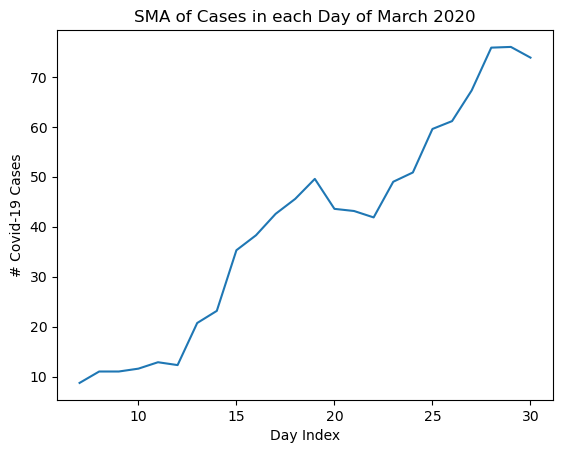

In [41]:
plt.plot(bc_data['SMA'])
plt.xlabel('Day Index')
plt.ylabel('# Covid-19 Cases')
plt.title('SMA of Cases in each Day of March 2020')
plt.show()

In [42]:
# We see that the SMA shows a clear uptrend in the first month's data of our dataset. 
# To support this assumption mathematically, we also need to fit a model to our observation data against a time index to show the statistically significant 
# relationship that exists between the two: observed_cases_t = bo + b1 * t + observed_error_t 

In [43]:
bc_data['time_index'] = np.arange(1,np.size(bc_data['cases'])+1)  # time index variable, beginning from 1 and culminating to 31, representing each day number for March 2020

In [44]:
Y = bc_data['cases']
X = add_constant(range(1,len(Y)+1))  # the independent variable will have values considered [1, 2, 3, 4, ..., 31==len(Y)], and the model will also contain a constant term
model = linear_model.OLS(Y, X)

In [45]:
results = model.fit()

In [46]:
print(results.params)

const   -6.548387
x1       3.048387
dtype: float64


In [47]:
a = results.params[0]
b = results.params[1]

In [48]:
print(results.pvalues)  # both coefs are statistically significant -> the assumption that there is a linear relationship between Y and time holds 

const    4.049709e-01
x1       6.126224e-08
dtype: float64


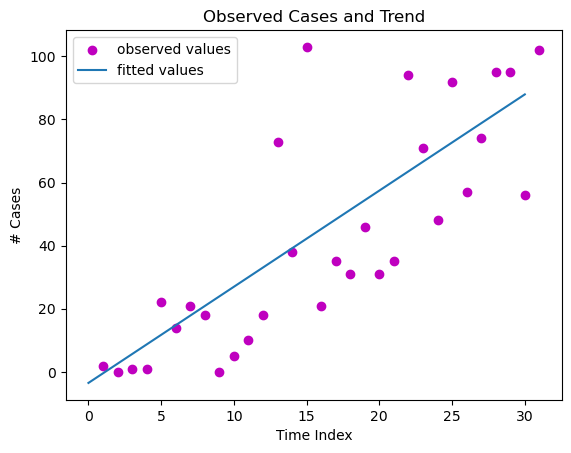

In [49]:
cases_hat =  results.fittedvalues  # =  results.params[0] + results.params[1] * bc_data['time_index'] 
plt.scatter(bc_data['time_index'], bc_data['cases'], marker='o', color='m', label='observed values')
plt.plot(cases_hat, label='fitted values')
plt.title('Observed Cases and Trend')
plt.xlabel('Time Index')
plt.ylabel('# Cases')
plt.legend()
plt.show()

In [50]:
# so, to extrapolate, we just add a time index variable to the df we have data on all our methods in ('ba_data') and then just use the linear trend formula
ba_data['time_index'] = np.arange(1, ba_data.shape[0]+1)
ba_data['holt'] = a + b * ba_data['time_index']

In [51]:
ba_data.head()

,date,countriesAndTerritories_x,cases,day,month,year,naive,SMA,wma,time_index,holt
0,2020-03-01,Greece,2,1,3,2020,2,NaN,NaN,1,-3.500000
1,2020-03-02,Greece,0,2,3,2020,0,NaN,NaN,2,-0.451613
2,2020-03-03,Greece,1,3,3,2020,1,NaN,NaN,3,2.596774
3,2020-03-04,Greece,1,4,3,2020,1,NaN,NaN,4,5.645161
4,2020-03-05,Greece,22,5,3,2020,22,NaN,NaN,5,8.693548


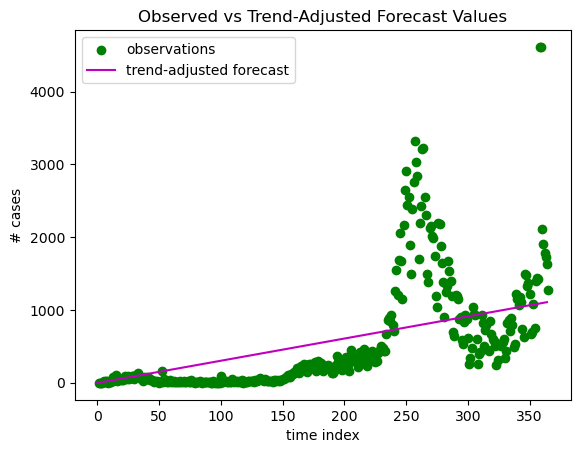

In [52]:
plt.scatter(ba_data['time_index'], ba_data['cases'], marker='o', color='green', label='observations')
plt.plot(ba_data['holt'], color='m', label='trend-adjusted forecast')
plt.legend()
plt.xlabel('time index')
plt.ylabel('# cases')
plt.title('Observed vs Trend-Adjusted Forecast Values')
plt.show()

In [53]:
# on March 23 we had the first quarantine that slowed down the transmission of the virus (and halted the trend, something that isn't incorporated in the data that we consider to fit our 
# model), but after that period the trend continued as is and we see that after some months our predictions seem to be pretty close.
# However, they it is clear that the relationship between cases and time stops having linear characteristics after mid 2020.

In [147]:
indexes_to_consider = np.array(list(set(ba_data['cases'].index) - set(ba_data['cases'][ba_data['cases'] == 0].index)))
MAD_holt = round(abs(ba_data.loc[indexes_to_consider, 'cases']-ba_data.loc[indexes_to_consider, 'holt']).sum()/indexes_to_consider.size)
MAD_holt

401

In [146]:
(ba_data.loc[indexes_to_consider, 'cases']-ba_data.loc[indexes_to_consider, 'holt'])

0        5.500000
1        0.451613
2       -1.596774
3       -4.645161
4       13.306452
          ...    
360    809.080645
361    686.032258
362    631.983871
363    526.935484
364    162.887097
Length: 364, dtype: float64

In [55]:
tr_signal_holt = (ba_data['cases'] - ba_data['holt']).sum() / MAD_holt
print(tr_signal_holt)

886.6182795698842


In [56]:
# To see if our model gives valid predictions (ON THE GIVEN DATA for march), we need to study the residuals of our model and check for LINE attributes

In [57]:
residuals = results.resid

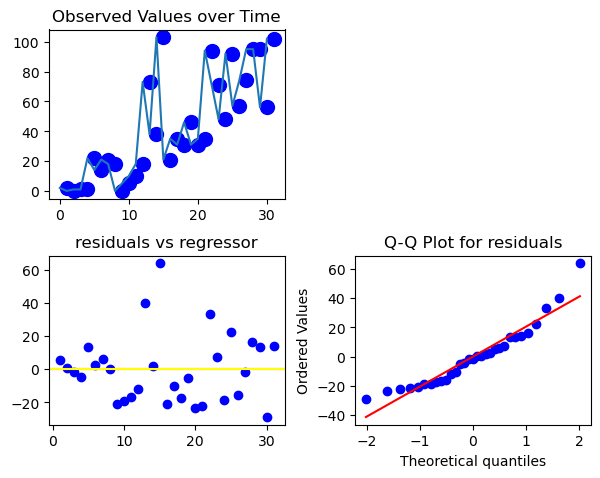

In [58]:
fig, ax = plt.subplots(2, 2)
fig.tight_layout(pad=2)

# first plot to check whether the relationship between Y and X is actually linear in the observation period 
plt.axes(ax[0,0])
plt.scatter(bc_data['time_index'], bc_data['cases'], marker='o', color='blue', s=100)
plt.plot(bc_data['cases'])
plt.title('Observed Values over Time')

# current axis: first row, first column
plt.axes(ax[1,0])
plt.scatter(bc_data['time_index'], residuals, marker='o', color='blue')
ax[1,0].axhline(0, color='red')
ax[1,0].axhline(np.mean(residuals), color='yellow')
plt.title('residuals vs regressor')

# second plot: qqplot for residuals
plt.axes(ax[1,1])
import scipy.stats as stats 
stats.probplot(residuals, dist='norm', plot=plt)
plt.title('Q-Q Plot for residuals')


fig.delaxes(ax[0,1])  # get rid of the extra subplot 
plt.show()

In [59]:
# The relationship between the time index and # cases seems to be approximately linear in the initial period under study. 
# The residuals don't seem to depart a lot from a straight line in the Q-Q plot, so it is not that we depart a lot from the normality assumption. 
# The mean of residuals is (approximately) zero and, ignoring a few outliers, we can see than we have almost the same amount of residual values above
# and below the mean: sum(residuals>0)=15, sum(residuals<0)=16.
# The residuals seem to be independent, as there is no clear pattern in their values over time. 
# Last, the variance (from inspecting the graph) seems to differ for the different regressor values, so the hypothesis of heteroscedasticity doesn't seem to hold
# => to get trustworthy forecasts, we would need to use heteroscedasticity-robust methods of estimating our model (e.g. GLS). 

### B-d: TREND and SEASONALITY-adjusted FORECASTING (holt-winter's method)

In [60]:
ba_data.head()

,date,countriesAndTerritories_x,cases,day,month,year,naive,SMA,wma,time_index,holt
0,2020-03-01,Greece,2,1,3,2020,2,NaN,NaN,1,-3.500000
1,2020-03-02,Greece,0,2,3,2020,0,NaN,NaN,2,-0.451613
2,2020-03-03,Greece,1,3,3,2020,1,NaN,NaN,3,2.596774
3,2020-03-04,Greece,1,4,3,2020,1,NaN,NaN,4,5.645161
4,2020-03-05,Greece,22,5,3,2020,22,NaN,NaN,5,8.693548


In [61]:
first_DOM_index = []
for i in range(len(ba_data['day'])):
    if ba_data['day'][i] == 1:
        first_DOM_index.append(i)  # ba_data is zero-indexed and with continuous indexes (bc prior index was reset somewhere above) 

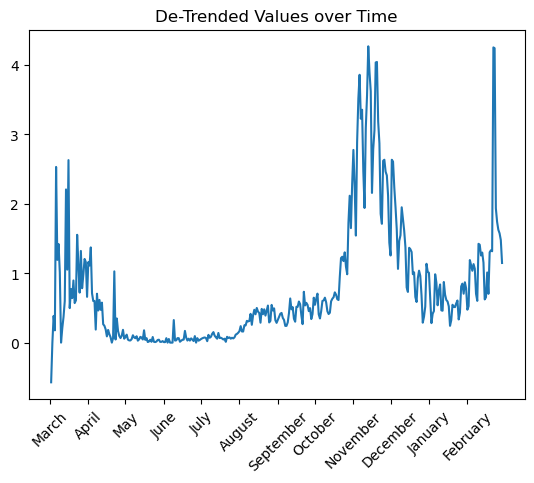

In [62]:
# ba_data contains data on the first year only - we visually check for any seasonal cycles in our DE-TRENDED data
plt.plot(ba_data['time_index'], ba_data['cases'] / ba_data['holt'])
#plt.scatter(ba_data['time_index'], ba_data['cases'] / ba_data['holt'], marker='o', color='blue', s=100)
plt.xticks(ticks=first_DOM_index, labels=['March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'January', 'February'], rotation=45)
plt.title('De-Trended Values over Time')
plt.show()

# the unique negative value has to do with the first trend estimate which is negative 

In [63]:
# We would expect to observe the following behavior; while we approach winter (presumably from late october onwards), we would expect
# to see a surge in positive cases as ppl start to gather in closed spaces -> we can see that in our data for the 4th quarter

# As spring is near, and the temperatures are rising, allowing for people to start mass gathering (even in open spaces), we would
# expect the cases to explode again -> we see that in the 1st quarter's data (from late february up to late march, cases skyrocket)

# Then, during the summer's hot season, we would expect to see an increase again as most people go on holidays - we observe an increas
# and subsequent decrease during the 3rd quarter. 

# in the second quarter there was no such clear movement due to the lockdown that had been imposed 

In [64]:
ba_data['date'] = pd.to_datetime(ba_data['date'])
test = [] 
for i in range(ba_data.shape[0]):
    test.append(ba_data['date'][i].quarter)
ba_data['quarter'] = test

In [65]:
ba_data.head()

,date,countriesAndTerritories_x,cases,day,month,year,naive,SMA,wma,time_index,holt,quarter
0,2020-03-01,Greece,2,1,3,2020,2,NaN,NaN,1,-3.500000,1
1,2020-03-02,Greece,0,2,3,2020,0,NaN,NaN,2,-0.451613,1
2,2020-03-03,Greece,1,3,3,2020,1,NaN,NaN,3,2.596774,1
3,2020-03-04,Greece,1,4,3,2020,1,NaN,NaN,4,5.645161,1
4,2020-03-05,Greece,22,5,3,2020,22,NaN,NaN,5,8.693548,1


In [66]:
quarterly_parameters = ((ba_data['cases']/ba_data['holt']).dropna()).groupby(ba_data['quarter']).mean()  # NaNs could arise if 
# we got a zero estimate through our trend-adjusted forecast
#working[ba_data['quarter'][0]]
    

In [67]:
normalized_single_period = (quarterly_parameters / quarterly_parameters.mean()) * 1. # where 1 = the mean value we want to achieve

In [68]:
working = [] 
for i in range(ba_data.shape[0]):
    working.append(normalized_single_period[ba_data.loc[i, 'quarter']])
ba_data['seasonal_factor'] = working

In [69]:
ba_data.head()

,date,countriesAndTerritories_x,cases,day,month,year,naive,SMA,wma,time_index,holt,quarter,seasonal_factor
0,2020-03-01,Greece,2,1,3,2020,2,NaN,NaN,1,-3.500000,1,1.242148
1,2020-03-02,Greece,0,2,3,2020,0,NaN,NaN,2,-0.451613,1,1.242148
2,2020-03-03,Greece,1,3,3,2020,1,NaN,NaN,3,2.596774,1,1.242148
3,2020-03-04,Greece,1,4,3,2020,1,NaN,NaN,4,5.645161,1,1.242148
4,2020-03-05,Greece,22,5,3,2020,22,NaN,NaN,5,8.693548,1,1.242148


In [70]:
level = (ba_data['cases'] / ba_data['holt'])[:32]
trend = ba_data['holt'][:32]
seasonal_factor = ba_data['seasonal_factor'][:32]

In [71]:
systematic_component = level * trend * seasonal_factor
random_component = bc_data['cases'] / (trend * seasonal_factor)

In [72]:
approx = systematic_component + random_component

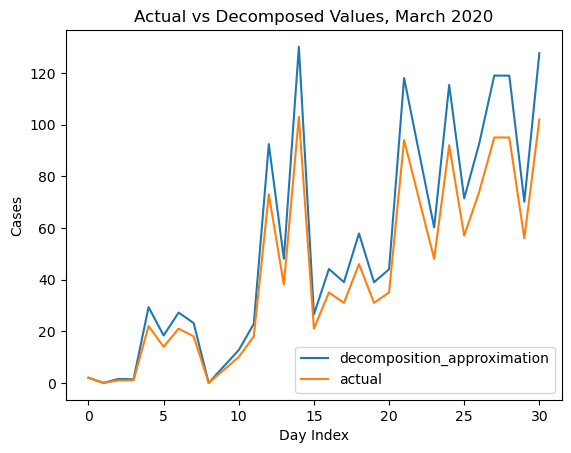

In [73]:
plt.plot(approx, label='decomposition_approximation')
plt.plot(bc_data['cases'], label='actual')
plt.xlabel('Day Index')
plt.ylabel('Cases')
plt.title('Actual vs Decomposed Values, March 2020')
plt.legend()
plt.show()

In [74]:
# working only on the 'available' data (aka march of 2020)
march1 = [b] 
for i in range(bc_data.shape[0]):
    march1.append((level[i] + trend[i]) * ba_data['seasonal_factor'][i+1]) 

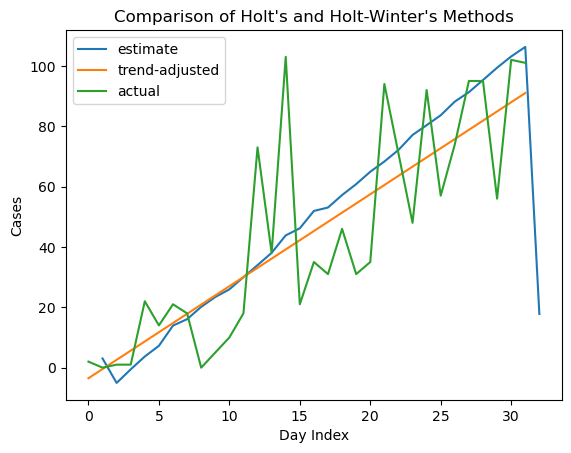

In [75]:
plt.plot(ba_data['time_index'][:32], march1, label='estimate')
plt.plot(trend, label='trend-adjusted')
plt.plot(ba_data['cases'][:32], label='actual')
plt.xlabel('Day Index')
plt.ylabel('Cases')
plt.title('Comparison of Holt\'s and Holt-Winter\'s Methods')
plt.legend()
plt.show()

In [76]:
rest = [] 
for i in range(bc_data.shape[0]+1, ba_data.shape[0]):
    rest.append((level[bc_data.shape[0]-1] + (i - bc_data.shape[0]) * cases_hat[bc_data.shape[0]-1]) * ba_data['seasonal_factor'][i])

In [77]:
holt_winters = march1 + rest 
ba_data['winters'] = holt_winters

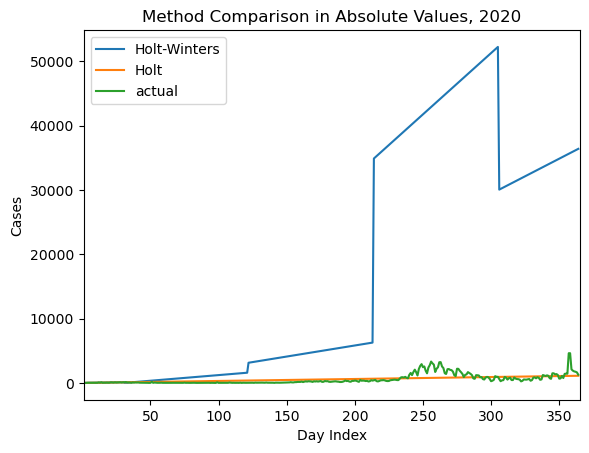

In [96]:
plt.plot(holt_winters, label='Holt-Winters')
plt.plot(ba_data['holt'], label='Holt')
plt.plot(ba_data['cases'], label='actual')
plt.xlabel('Day Index')
plt.ylabel('Cases')
plt.title('Method Comparison in Absolute Values, 2020')
plt.legend()
plt.xlim((1,365))
plt.show()

/var/folders/fp/b19fbw2j41z9_lyxq1cyd88h0000gn/T/ipykernel_10940/3945128036.py:1: RuntimeWarning: invalid value encountered in log10
  plt.plot(np.log10(holt_winters), label='Holt-Winter')
/Users/chkapsalis/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/chkapsalis/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


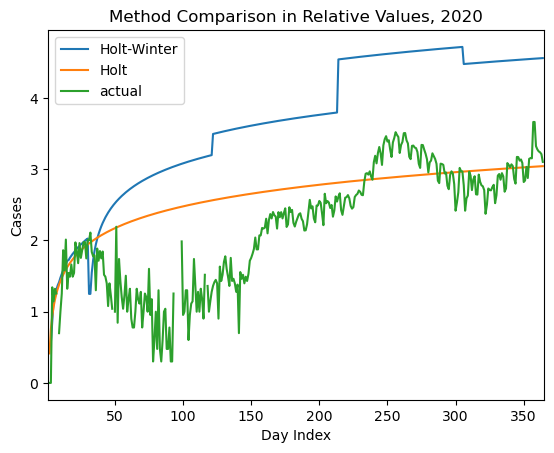

In [97]:
plt.plot(np.log10(holt_winters), label='Holt-Winter')
plt.plot(np.log10(ba_data['holt']), label='Holt')
plt.plot(np.log10(ba_data['cases']), label='actual')
plt.xlabel('Day Index')
plt.ylabel('Cases')
plt.title('Method Comparison in Relative Values, 2020')
plt.legend()
plt.xlim((1,365))
plt.show()

In [98]:
# too bad a forecast, it has to do with the fact that lockdowns broke the seasonality cycles that could arise otherwise, 
# and our limited mathematical toolset doesn't allow for a better approximation 

In [99]:
indexes_to_consider = np.array(list(set(ba_data['cases'].index) - set(ba_data['cases'][ba_data['cases'] == 0].index)))
MAD_winters = round(sum(ba_data.loc[indexes_to_consider, 'cases']-ba_data.loc[indexes_to_consider, 'winters'])/indexes_to_consider.size)
print(MAD_winters)

-17555


In [100]:
tr_signal_winters = (ba_data['cases'] - ba_data['winters']).sum() / MAD_winters
print(tr_signal_winters)

357.3631487213613


# C

In [101]:
                            ### DELETE THIS ### 
# The 'final' dataframe we worked on in question A is free from nan and missing values, as well as inconsistensies in our data.
# Thus we're going to create a df that will be similar to 'ba_data', but will contain data (and forecasts based on the various
# methods under study) for the second year only. 
#c_data = final[(final['date'] >= datetime.datetime(2021,3,1)) & (final['date'] <= datetime.datetime(2022,2,28))]
#c_data['day'] = [list(c_data['date'])[i].day for i in range(c_data.shape[0])]
#c_data['month'] = [list(c_data['date'])[i].month for i in range(c_data.shape[0])]
#c_data['year'] = [list(c_data['date'])[i].year for i in range(c_data.shape[0])]
#c_data.drop(['deaths','NA'], axis=1, inplace=True)
#c_data.reset_index(inplace=True)
#c_data.drop('index', axis=1, inplace=True)
#c_data.head()

In [102]:
gr_data_c = final[(final['countriesAndTerritories_x'] == 'Greece') & (final['date'] <= datetime.datetime(2022,2,28)) & (final['date'] >= datetime.datetime(2021,3,1))]
gr_data_c.drop(['deaths','NA'],axis=1,inplace=True)
gr_data_c.reset_index(inplace=True)
gr_data_c.drop('index', axis=1, inplace=True)
print(f"There are {sum(gr_data_c['cases'].isna())} NaN values for positive cases in Greece in that period.")

gr_data_c['day'] = [list(gr_data_c['date'])[i].day for i in range(gr_data_c.shape[0])]
gr_data_c['month'] = [list(gr_data_c['date'])[i].month for i in range(gr_data_c.shape[0])]
gr_data_c['year'] = [list(gr_data_c['date'])[i].year for i in range(gr_data_c.shape[0])]
gr_data_c.head()

There are 0 NaN values for positive cases in Greece in that period.


/var/folders/fp/b19fbw2j41z9_lyxq1cyd88h0000gn/T/ipykernel_10940/115430868.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gr_data_c.drop(['deaths','NA'],axis=1,inplace=True)
/var/folders/fp/b19fbw2j41z9_lyxq1cyd88h0000gn/T/ipykernel_10940/115430868.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gr_data_c.drop('index', axis=1, inplace=True)
/var/folders/fp/b19fbw2j41z9_lyxq1cyd88h0000gn/T/ipykernel_10940/115430868.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

,date,countriesAndTerritories_x,cases,day,month,year
0,2021-03-01,Greece,1170.0,1,3,2021
1,2021-03-02,Greece,2312.0,2,3,2021
2,2021-03-03,Greece,2697.0,3,3,2021
3,2021-03-04,Greece,2217.0,4,3,2021
4,2021-03-05,Greece,2181.0,5,3,2021


There are 0 outliers, comprising 0.0% of the available data.


/var/folders/fp/b19fbw2j41z9_lyxq1cyd88h0000gn/T/ipykernel_10940/3059847594.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gr_march_c['Z-Score'] = (gr_march_c['cases'] - gr_march_c['cases'].mean()) / gr_march_c['cases']


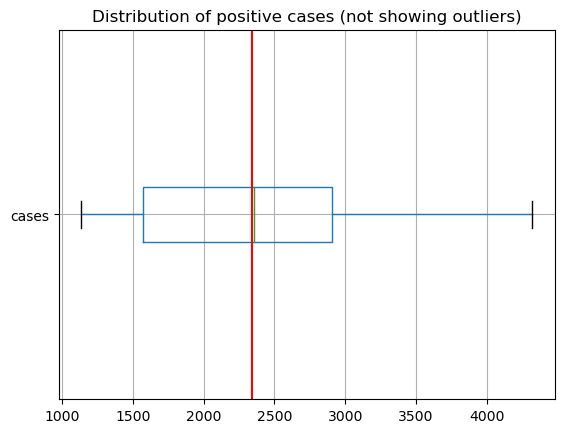

In [103]:
gr_march_c = gr_data[(gr_data['date'] >= datetime.datetime(2021,3,1)) & (gr_data['date'] <= datetime.datetime(2021,3,31))]
threshold = 3 
gr_march_c['Z-Score'] = (gr_march_c['cases'] - gr_march_c['cases'].mean()) / gr_march_c['cases']
gr_outliers_c = gr_march_c[abs(gr_march_c['Z-Score']) > threshold]  # epileksame afto to method logw toy oti einai to pio synhthes, bebaia - the transmission of a virus, especially in the setting of the early 
print(f"There are {gr_outliers_c.shape[0]} outliers, comprising {round(gr_outliers_c.shape[0]/gr_march_c.shape[0], 2) * 100}% of the available data.")


# Inspecting the Distribution of the Positive Cases Count in Greece, Mar 2021
gr_march_c.boxplot('cases', vert=False, showfliers=True)
plt.title('Distribution of positive cases (not showing outliers)')
plt.axvline(gr_march_c['cases'].mean(), color='red')
plt.show()

Outliers are observed in consecutive data points once again, showcasing the positive case surge during that period. 

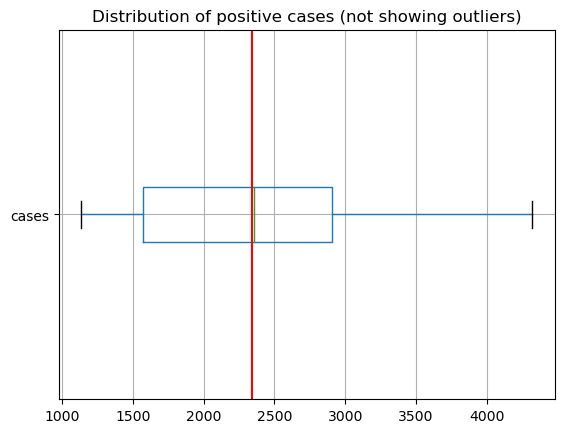

In [104]:
gr_march_c.boxplot('cases', vert=False, showfliers=False)
plt.title('Distribution of positive cases (not showing outliers)')
plt.axvline(gr_march_c['cases'].mean(), color='red')
plt.show()
# the distribution is indeed rather symmetric

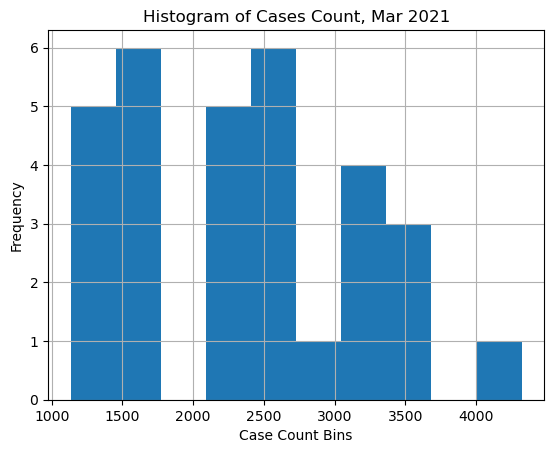

In [105]:
# The histogram also does not depart much from randomness
gr_march_c.hist('cases')
plt.xlabel('Case Count Bins')
plt.ylabel('Frequency')
plt.title('Histogram of Cases Count, Mar 2021')
plt.show()

### Applying the naive, simple moving average and weighted moving average methods on the second year's data

In [106]:
gr_data_c['naive'] = naive(gr_data_c, 2021)
gr_data_c['SMA'] = SMA(gr_data_c, 2021)
gr_data_c['wma'] = WMA(gr_data_c, 2021)
gr_data_c.head(8)

/var/folders/fp/b19fbw2j41z9_lyxq1cyd88h0000gn/T/ipykernel_10940/184716769.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gr_data_c['naive'] = naive(gr_data_c, 2021)
/var/folders/fp/b19fbw2j41z9_lyxq1cyd88h0000gn/T/ipykernel_10940/184716769.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gr_data_c['SMA'] = SMA(gr_data_c, 2021)
/var/folders/fp/b19fbw2j41z9_lyxq1cyd88h0000gn/T/ipykernel_10940/184716769.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

,date,countriesAndTerritories_x,cases,day,month,year,naive,SMA,wma
0,2021-03-01,Greece,1170.0,1,3,2021,1170.0,NaN,NaN
1,2021-03-02,Greece,2312.0,2,3,2021,2312.0,NaN,NaN
2,2021-03-03,Greece,2697.0,3,3,2021,2697.0,NaN,NaN
3,2021-03-04,Greece,2217.0,4,3,2021,2217.0,NaN,NaN
4,2021-03-05,Greece,2181.0,5,3,2021,2181.0,NaN,NaN
5,2021-03-06,Greece,2301.0,6,3,2021,2301.0,NaN,NaN
6,2021-03-07,Greece,1142.0,7,3,2021,1142.0,NaN,NaN
7,2021-03-08,Greece,1161.0,8,3,2021,1161.0,2002.857143,2025.071429


/Users/chkapsalis/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


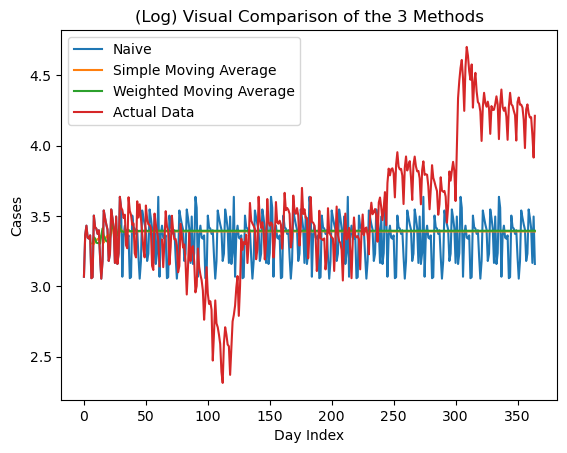

In [107]:
plt.plot(np.log10(gr_data_c['naive']), label = 'Naive')
plt.plot(np.log10(gr_data_c['SMA']), label = 'Simple Moving Average')
plt.plot(np.log10(gr_data_c['wma']), label = 'Weighted Moving Average')
plt.plot(np.log10(gr_data_c['cases']), label = 'Actual Data')
plt.xlabel('Day Index')
plt.ylabel('Cases')
plt.title('(Log) Visual Comparison of the 3 Methods')
plt.legend()
plt.show()

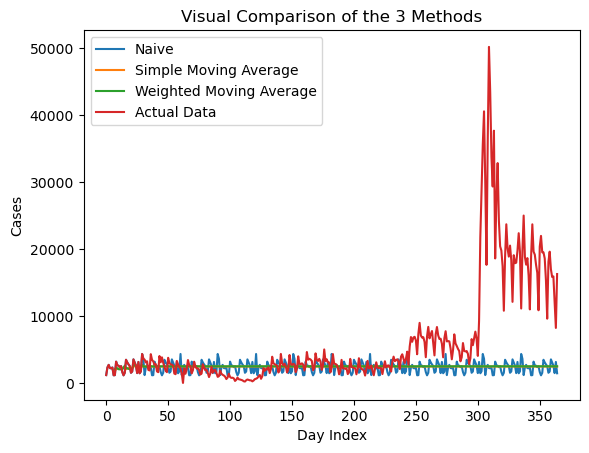

In [108]:
plt.plot(gr_data_c['naive'], label = 'Naive')
plt.plot(gr_data_c['SMA'], label = 'Simple Moving Average')
plt.plot(gr_data_c['wma'], label = 'Weighted Moving Average')
plt.plot(gr_data_c['cases'], label = 'Actual Data')
plt.xlabel('Day Index')
plt.ylabel('Cases')
plt.title('Visual Comparison of the 3 Methods')
plt.legend()
plt.show()

In [109]:
indexes_to_consider = np.array(list(set(gr_data_c['cases'].index) - set(gr_data_c['cases'][gr_data_c['cases'] == 0].index)))
MAD_naive_c = round(abs(gr_data_c.loc[indexes_to_consider, 'cases']-gr_data_c.loc[indexes_to_consider, 'naive']).sum()/indexes_to_consider.size, 2)
MAD_sma_c = round(abs(gr_data_c.loc[indexes_to_consider, 'cases'][indexes_to_consider >= 7]-gr_data_c.loc[indexes_to_consider, 'SMA'][indexes_to_consider >= 7]).sum()/indexes_to_consider.size, 2)
MAD_wma_c = round(abs(gr_data_c.loc[indexes_to_consider, 'cases'][indexes_to_consider >= 7]-gr_data_c.loc[indexes_to_consider, 'wma'][indexes_to_consider >= 7]).sum()/indexes_to_consider.size, 2)

In [111]:
print(MAD_naive_c, MAD_sma_c, MAD_wma_c)

4502.75 4358.96 4351.49


In [112]:
tr_signal_naive_c = (gr_data_c['cases'] - gr_data_c['naive']).sum() / MAD_naive_c
tr_signal_sma_c = (gr_data_c['cases'] - gr_data_c['SMA']).sum() / MAD_sma_c
tr_signal_wma_c = (gr_data_c['cases'] - gr_data_c['wma']).sum() / MAD_wma_c
print(f"Tracking Signal naive: {round(tr_signal_naive_c,2)}, Tracking Signal SMA: {round(tr_signal_sma_c,2)}, Tracking Signal WMA: {round(tr_signal_wma_c,2)}")

Tracking Signal naive: 307.28, Tracking Signal SMA: 307.95, Tracking Signal WMA: 306.33


In [113]:
# this time, the extreme movements were less severe, so the closer following of the current movements by the wma actually had a 
# positive impact in the accuracy of our forecasts

### Holt's method on the second year's dataset 

In [114]:
# our 'available' data
gr_c_march = gr_data_c[(gr_data_c['month'] == 3) & (gr_data_c['year'] == 2021)][['date','cases','SMA']]

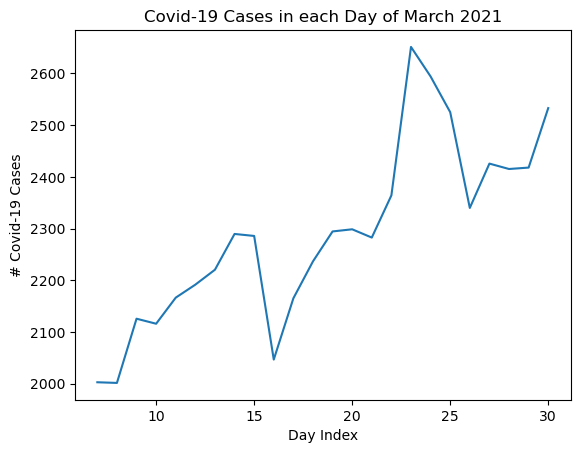

In [115]:
plt.plot(gr_c_march['SMA'])
plt.xlabel('Day Index')
plt.ylabel('# Covid-19 Cases')
plt.title('Covid-19 Cases in each Day of March 2021')
plt.show()

In [116]:
# Once again we can see an uptrend, although with more mixed movements than in the first year

In [117]:
gr_c_march['time_index'] = np.arange(1,np.size(gr_c_march['cases'])+1)  # time index variable, beginning from 1 and culminating to 31, representing each day number for March 2020
Y = gr_c_march['cases']
X = add_constant(range(1,len(Y)+1))  # the independent variable will have values considered [1, 2, 3, 4, ..., 31==len(Y)], and the model will also contain a constant term
model = linear_model.OLS(Y, X)

In [118]:
results = model.fit()
print(results.params)
a = results.params[0]
b = results.params[1]
print(results.pvalues)  # both coefs are statistically significant -> the assumption that there is a linear relationship between Y and time holds 


const    1881.464516
x1         28.757258
dtype: float64
const    6.769135e-07
x1       8.744838e-02
dtype: float64


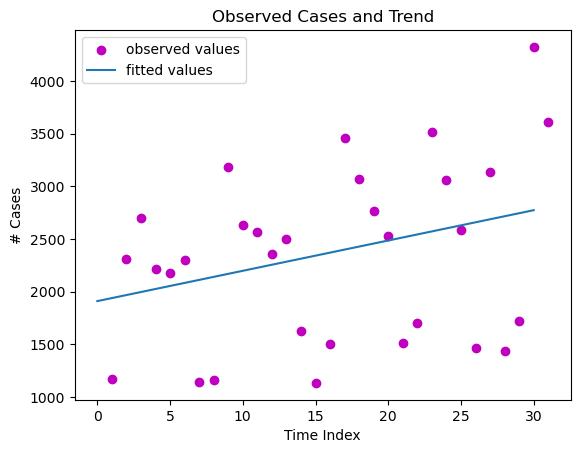

In [119]:
cases_hat =  results.fittedvalues  # =  results.params[0] + results.params[1] * bc_data['time_index'] 
plt.scatter(gr_c_march['time_index'], gr_c_march['cases'], marker='o', color='m', label='observed values')
plt.plot(cases_hat, label='fitted values')
plt.title('Observed Cases and Trend')
plt.xlabel('Time Index')
plt.ylabel('# Cases')
plt.legend()
plt.show()

In [120]:
gr_data_c['time_index'] = np.arange(1, gr_data_c.shape[0]+1)
gr_data_c['holt'] = a + b * gr_data_c['time_index']
gr_data_c.head()

/var/folders/fp/b19fbw2j41z9_lyxq1cyd88h0000gn/T/ipykernel_10940/4062475699.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gr_data_c['time_index'] = np.arange(1, gr_data_c.shape[0]+1)
/var/folders/fp/b19fbw2j41z9_lyxq1cyd88h0000gn/T/ipykernel_10940/4062475699.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gr_data_c['holt'] = a + b * gr_data_c['time_index']


,date,countriesAndTerritories_x,cases,day,month,year,naive,SMA,wma,time_index,holt
0,2021-03-01,Greece,1170.0,1,3,2021,1170.0,NaN,NaN,1,1910.221774
1,2021-03-02,Greece,2312.0,2,3,2021,2312.0,NaN,NaN,2,1938.979032
2,2021-03-03,Greece,2697.0,3,3,2021,2697.0,NaN,NaN,3,1967.736290
3,2021-03-04,Greece,2217.0,4,3,2021,2217.0,NaN,NaN,4,1996.493548
4,2021-03-05,Greece,2181.0,5,3,2021,2181.0,NaN,NaN,5,2025.250806


In [121]:
indexes_to_consider = np.array(list(set(gr_data_c['cases'].index) - set(gr_data_c['cases'][gr_data_c['cases'] == 0].index)))
MAD_holt_c = round((gr_data_c.loc[indexes_to_consider, 'cases']-gr_data_c.loc[indexes_to_consider, 'holt']).sum()/indexes_to_consider.size)
print(MAD_holt_c)

-1026


In [122]:
tr_signal_holt_c = (gr_data_c['cases'] - gr_data_c['holt']).sum() / MAD_holt_c
print(tr_signal_holt_c)

367.45770059108503


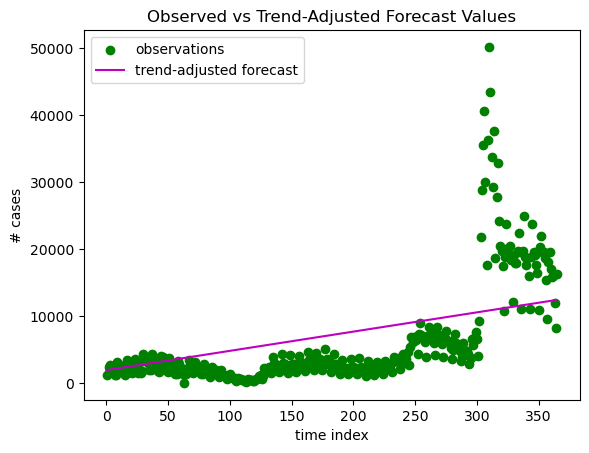

In [123]:
plt.scatter(gr_data_c['time_index'], gr_data_c['cases'], marker='o', color='green', label='observations')
plt.plot(gr_data_c['holt'], color='m', label='trend-adjusted forecast')
plt.legend()
plt.xlabel('time index')
plt.ylabel('# cases')
plt.title('Observed vs Trend-Adjusted Forecast Values')
plt.show()

### Holt-Winter's method on the second year's data

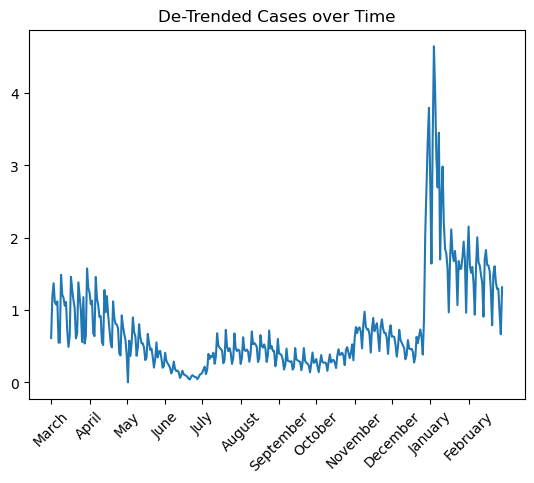

In [124]:
first_DOM_index_c = []
for i in range(len(gr_data_c['day'])):
    if gr_data_c['day'][i] == 1:
        first_DOM_index_c.append(i)  # gr_data_c is zero-indexed and with continuous indexes (bc prior index was reset somewhere above) 

# gr_data_c contains data on the second year only - we visually check for any seasonal cycles in our DE-TRENDED data
plt.plot(gr_data_c['cases'] / gr_data_c['holt'])
#plt.scatter(gr_data_c['time_index'], gr_data_c['cases'] / gr_data_c['holt'], marker='o', color='blue', s=100)
plt.xticks(ticks=first_DOM_index_c, labels=['March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'January', 'February'], rotation=45)
plt.title('De-Trended Cases over Time')
plt.show()

In [115]:
# once again, we observe approximately 4 seasonal cycles, each of duration equal to one quarter, approximately matching to the 
# quarters of the year

# the reasoning behind this assumption of ours is the same as before;
# July-September was the summer's hot season, so there was increase in transmission due to places getting crowded by holiday goers
# oct-dec was the cooling period of the year, so people 
# apr-jun was a period of transmission slowdown, not showing the same behaviour as in the other quarters that clearly
# jan-mar showed an increase and subsequent decrease as in year 1, but this time the increase came in january, and that happened
# due to the end of the lockdown and the spread of the super transmissive 'omicron' variant



# so, again in this case, the cycles we consider match with the quarters of the year
temp = [] 
for i in range(gr_data_c.shape[0]):
    temp.append(gr_data_c['date'][i].quarter)
gr_data_c['quarter'] = temp
quarterly_parameters = ((gr_data_c['cases']/gr_data_c['holt']).dropna()).groupby(gr_data_c['quarter']).mean()  # NaNs could arise if 


/var/folders/fp/b19fbw2j41z9_lyxq1cyd88h0000gn/T/ipykernel_27931/1952641455.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gr_data_c['quarter'] = temp


quarter
1    1.523790
2    0.481813
3    0.379979
4    0.622501
dtype: float64

In [116]:
# as expected, the first quarter's effect is the largest by far

In [117]:
normalized_single_period = (quarterly_parameters / quarterly_parameters.mean()) * 1. # where 1 = the mean value we want to achieve


quarter
1    2.026260
2    0.640692
3    0.505277
4    0.827772
dtype: float64

In [118]:
working = [] 
for i in range(gr_data_c.shape[0]):
    working.append(normalized_single_period[gr_data_c.loc[i, 'quarter']])
gr_data_c['seasonal_factor'] = working

/var/folders/fp/b19fbw2j41z9_lyxq1cyd88h0000gn/T/ipykernel_27931/592760439.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gr_data_c['seasonal_factor'] = working


In [119]:
level = (gr_data_c['cases'] / gr_data_c['holt'])[:32]
trend = gr_data_c['holt'][:32]
seasonal_factor = gr_data_c['seasonal_factor'][:32]
systematic_component = level * trend * seasonal_factor
random_component = gr_c_march['cases'] / (trend * seasonal_factor)
approx = systematic_component + random_component

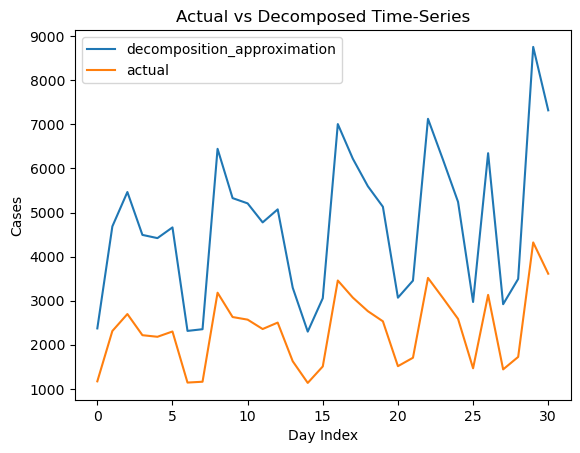

In [120]:
plt.plot(approx, label='decomposition_approximation')
plt.plot(gr_c_march['cases'], label='actual')
plt.xlabel('Day Index')
plt.ylabel('Cases')
plt.title('Actual vs Decomposed Time-Series')
plt.legend()
plt.show()

In [121]:
# working only on the 'available' data (aka march of 2020)
march1_c = [b] 
for i in range(gr_c_march.shape[0]):
    march1_c.append((level[i] + trend[i]) * gr_data_c['seasonal_factor'][i+1]) 

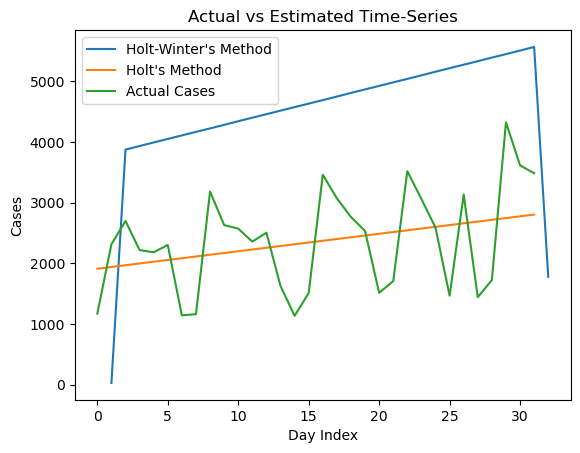

In [122]:
plt.plot(gr_data_c['time_index'][:32], march1_c, label='Holt-Winter\'s Method')
plt.plot(trend, label='Holt\'s Method')
plt.plot(gr_data_c['cases'][:32], label='Actual Cases')
plt.xlabel('Day Index')
plt.ylabel('Cases')
plt.title('Actual vs Estimated Time-Series')
plt.legend()
plt.show()

In [123]:
rest = [] 
for i in range(gr_c_march.shape[0]+1, gr_data_c.shape[0]):
    rest.append((level[gr_c_march.shape[0]-1] + (i - gr_c_march.shape[0]) * cases_hat[gr_c_march.shape[0]-1]) * gr_data_c['seasonal_factor'][i])

In [124]:
holt_winters = march1 + rest 
gr_data_c['winters'] = holt_winters

/var/folders/fp/b19fbw2j41z9_lyxq1cyd88h0000gn/T/ipykernel_27931/498310773.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gr_data_c['winters'] = holt_winters


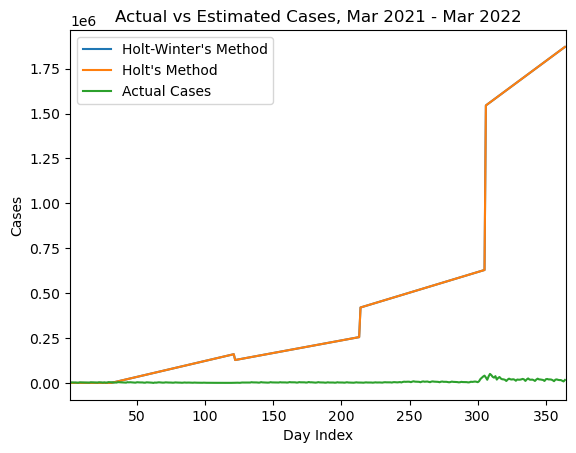

In [125]:
plt.plot(holt_winters, label='Holt-Winter\'s Method')
plt.plot(gr_data_c['winters'], label='Holt\'s Method')
plt.plot(gr_data_c['cases'], label='Actual Cases')
plt.xlabel('Day Index')
plt.ylabel('Cases')
plt.title('Actual vs Estimated Cases, Mar 2021 - Mar 2022')
plt.legend()
plt.xlim((1,365))
plt.show()

/var/folders/fp/b19fbw2j41z9_lyxq1cyd88h0000gn/T/ipykernel_27931/2487020300.py:1: RuntimeWarning: invalid value encountered in log10
  plt.plot(np.log10(holt_winters), label='Holt-Winter\'s Method')
/Users/chkapsalis/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


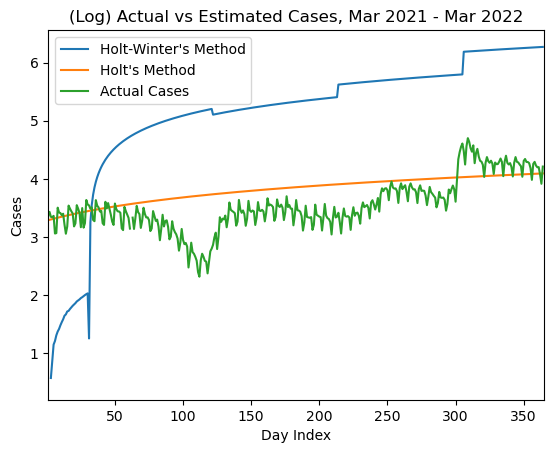

In [126]:
plt.plot(np.log10(holt_winters), label='Holt-Winter\'s Method')
plt.plot(np.log10(gr_data_c['holt']), label='Holt\'s Method')
plt.plot(np.log10(gr_data_c['cases']), label='Actual Cases')
plt.xlabel('Day Index')
plt.ylabel('Cases')
plt.title('(Log) Actual vs Estimated Cases, Mar 2021 - Mar 2022')
plt.legend()
plt.xlim((1,365))
plt.show()

In [127]:
indexes_to_consider = np.array(list(set(gr_data_c['cases'].index) - set(gr_data_c['cases'][gr_data_c['cases'] == 0].index)))
MAD_winters_c = round(sum(gr_data_c.loc[indexes_to_consider, 'cases']-gr_data_c.loc[indexes_to_consider, 'winters'])/indexes_to_consider.size)
print(MAD_winters_c)

-471474

In [128]:
tr_signal_winters_c = (gr_data_c['cases'] - gr_data_c['winters']).sum() / MAD_winters_c
print(tr_signal_winters_c)

364.11681719093116


# E

In [125]:
final['month'] = [i.month for i in final['date']]
final['year'] = [i.year for i in final['date']]

/var/folders/fp/b19fbw2j41z9_lyxq1cyd88h0000gn/T/ipykernel_10940/442582167.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['month'] = [i.month for i in final['date']]
/var/folders/fp/b19fbw2j41z9_lyxq1cyd88h0000gn/T/ipykernel_10940/442582167.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['year'] = [i.year for i in final['date']]


In [126]:
final.head()

,date,countriesAndTerritories_x,cases,deaths,NA,month,year
1802,2020-03-01,Bulgaria,4.0,NaN,True,3,2020
1803,2020-03-01,Croatia,2.0,0.0,False,3,2020
1805,2020-03-01,Czechia,3.0,0.0,False,3,2020
1808,2020-03-01,Finland,1.0,0.0,False,3,2020
1811,2020-03-01,Greece,2.0,0.0,False,3,2020


In [127]:
# we'll only consider the first year's data
final = final[(final['date'] >= datetime.datetime(2020,3,1)) & (final['date'] <= datetime.datetime(2021,2,28))]
final.reset_index(inplace=True)
final.drop(['index','deaths','NA'], axis=1, inplace=True)
final.head()

,date,countriesAndTerritories_x,cases,month,year
0,2020-03-01,Bulgaria,4.0,3,2020
1,2020-03-01,Croatia,2.0,3,2020
2,2020-03-01,Czechia,3.0,3,2020
3,2020-03-01,Finland,1.0,3,2020
4,2020-03-01,Greece,2.0,3,2020


In [128]:
final.sort_values(['countriesAndTerritories_x', 'year', 'month'], inplace=True)
final['dateKey'] = '(' + final['year'].astype('str') + ',' + final['month'].astype('str') + ')'

a = pd.pivot_table(data=final[(final['date'] >= datetime.datetime(2020,3,1)) & (final['date'] <= datetime.datetime(2021,2,28))][['countriesAndTerritories_x','cases','dateKey']], index='dateKey', columns = 'countriesAndTerritories_x', aggfunc='mean')

In [129]:
a.columns = a.columns.droplevel()

In [130]:
# time index creation 
temp = [] 
for i in range(a.shape[0]):
    time = a.index[i].split(',')
    if time[0] == "(2020":
        temp.append(int(time[1].replace(')','')) - 2)
    else:
        temp.append(int(time[1].replace(')','')) + 10)
a['time_index'] = temp
a.sort_values('time_index', inplace=True)

In [131]:
cols = list(a.columns)
cols.remove('time_index')
for country in cols:  # iterating through the list of countries we've considered
    Y = a[country]
    X = add_constant(range(1,len(Y)+1))  # the independent variable will have values considered [1, 2, 3, 4, ..., 31==len(Y)], and the model will also contain a constant term
    model = linear_model.OLS(Y, X)
    results = model.fit()
    a_hat = results.params[0]
    b_hat = results.params[1]
    a[f'{country}_holt'] = a_hat + b_hat * a['time_index']
    a[f'{country}_AF'] = a[country] / a[f'{country}_holt']

In [132]:
a.head()

countriesAndTerritories_x,Bulgaria,Croatia,Czechia,Finland,Greece,Hungary,Ireland,Lithuania,Norway,Portugal,...,Ireland_holt,Ireland_AF,Lithuania_holt,Lithuania_AF,Norway_holt,Norway_AF,Portugal_holt,Portugal_AF,Slovakia_holt,Slovakia_AF
dateKey,,,,,,,,,,,,,,,,,,,,,
"(2020,3)",14.064516,27.806452,106.967742,57.677419,42.225806,15.870968,104.322581,14.806452,164.032258,233.903226,...,-184.130818,-0.566568,-299.554498,-0.049428,-8.499811,-19.298342,-1011.956444,-0.231140,-1216.275738,-0.010741
"(2020,4)",37.633333,40.300000,146.200000,120.833333,42.566667,76.100000,579.233333,30.666667,89.333333,562.666667,...,-40.422081,-14.329627,-146.020372,-0.210016,29.096398,3.070254,-439.598875,-1.279955,-745.969673,-0.044819
"(2020,5)",31.548387,5.483871,52.290323,50.451613,10.516129,35.516129,141.225806,9.516129,21.064516,283.032258,...,103.286656,1.367319,7.513753,1.266495,66.692607,0.315845,132.758693,2.131930,-275.663609,-0.013925
"(2020,6)",82.333333,17.700000,90.133333,9.466667,16.400000,9.300000,16.100000,4.700000,15.200000,333.966667,...,246.995393,0.065183,161.047879,0.029184,104.288817,0.145749,705.116262,0.473633,194.642456,0.028257
"(2020,7)",216.161290,76.161290,148.290323,6.967742,34.451613,11.290323,19.096774,9.000000,13.354839,300.322581,...,390.704130,0.048878,314.582004,0.028609,141.885026,0.094124,1277.473830,0.235091,664.948520,0.031533


In [133]:
a = a.round(2)
a.head()


countriesAndTerritories_x,Bulgaria,Croatia,Czechia,Finland,Greece,Hungary,Ireland,Lithuania,Norway,Portugal,...,Ireland_holt,Ireland_AF,Lithuania_holt,Lithuania_AF,Norway_holt,Norway_AF,Portugal_holt,Portugal_AF,Slovakia_holt,Slovakia_AF
dateKey,,,,,,,,,,,,,,,,,,,,,
"(2020,3)",14.06,27.81,106.97,57.68,42.23,15.87,104.32,14.81,164.03,233.90,...,-184.13,-0.57,-299.55,-0.05,-8.50,-19.30,-1011.96,-0.23,-1216.28,-0.01
"(2020,4)",37.63,40.30,146.20,120.83,42.57,76.10,579.23,30.67,89.33,562.67,...,-40.42,-14.33,-146.02,-0.21,29.10,3.07,-439.60,-1.28,-745.97,-0.04
"(2020,5)",31.55,5.48,52.29,50.45,10.52,35.52,141.23,9.52,21.06,283.03,...,103.29,1.37,7.51,1.27,66.69,0.32,132.76,2.13,-275.66,-0.01
"(2020,6)",82.33,17.70,90.13,9.47,16.40,9.30,16.10,4.70,15.20,333.97,...,247.00,0.07,161.05,0.03,104.29,0.15,705.12,0.47,194.64,0.03
"(2020,7)",216.16,76.16,148.29,6.97,34.45,11.29,19.10,9.00,13.35,300.32,...,390.70,0.05,314.58,0.03,141.89,0.09,1277.47,0.24,664.95,0.03


In [140]:
MAD_GR_initial = abs(a['Greece']-a['Greece_holt']).sum()/a.shape[0]
print(round(MAD_GR_initial,5))  # poly mikro giati milame gia ta 'gnwsta' dedomena + doylevw me mesous opote einai pio smooth 

312.6775


In [135]:
countries = list(set(final['countriesAndTerritories_x']) - set(['Greece']))
print(countries)

['Hungary', 'Slovakia', 'Bulgaria', 'Croatia', 'Portugal', 'Ireland', 'Finland', 'Norway', 'Lithuania', 'Czechia']


In [136]:
temp = [] 
for i in a['time_index'].values:
    temp.append(a[a['time_index']==i][f'{country}_AF'][0])
#    r = [a.iloc[i,f'{country}_AF'] for country in countries]
#    temp.append(sum(r) / len(r))   
a['mu'] = temp

In [137]:
a['revised_gr'] = a['Greece_holt'] * a['mu']

In [139]:
MAD_GR_revised = abs(a['Greece']-a['revised_gr']).sum()/a.shape[0]
print(round(MAD_GR_revised,5))  # poly mikro giati milame gia ta 'gnwsta' dedomena + doylevw me mesous opote einai pio smooth 

325.20319


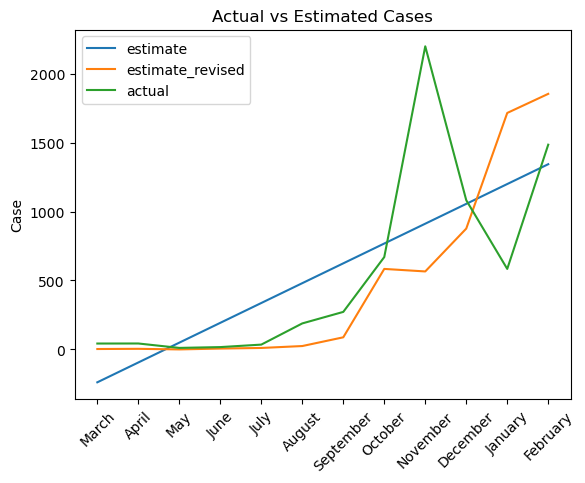

In [177]:
plt.plot(a['time_index'], a['Greece_holt'], label='estimate')
plt.plot(a['time_index'], a['revised_gr'], label='estimate_revised')
plt.plot(a['time_index'], a['Greece'], label='actual')
plt.legend()
plt.ylabel('Case')
plt.title('Actual vs Estimated')
plt.xticks(ticks = range(1,13), labels = ['March','April','May','June','July','August','September','October','November','December','January','February'],rotation=45)
plt.show()

In [178]:
# MAD gives a false image for the accuracy of the methods, bc the revised estimate curve approaches the actual data much better, 
# and it almost exclusively has positive deviations <> simple holt method gave both positive and negative, and they cancelled out 

In [141]:
MAPE_initial = 100 * (abs(a['Greece']-a['Greece_holt'])/a['Greece']).sum() / a['Greece'].size

In [142]:
MAPE_final = 100 * (abs(a['Greece']-a['revised_gr'])/a['Greece']).sum() / a['Greece'].size

In [143]:
print(MAPE_initial,MAPE_final)

315.01394514590504 75.45524621424664


In [183]:
# mape final < mape initial -> the revised forecast is much better, bc it accounts for the 
# mean error of all other european countries of similar characteristics population-wise, so we could say that it 
# takes into consideration the variance characteristics of somehow similar distributions, so it gives us a better sense of the 
# random movements of our data (?)